## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  

For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm

%matplotlib inline

#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

**Answer**

+ There are 294478 rows in the dataset

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

**Answer:**
+  There are 290584 unique users in the dataset

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

**Answer:**

+  Roughly 0.12 (12%) of users converted

In [5]:
df.query('converted == 1').shape[0] / df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

**Answer:**
+  There are 3893 times the `new_page` and `treatment` don't line up

In [6]:
new_pg_control = df.query('landing_page == "new_page" & group == "control"').shape[0]
old_pg_control = df.query('landing_page == "old_page" & group == "treatment"').shape[0]

new_pg_control + old_pg_control

3893

f. Do any of the rows have missing values?

**Answer:**
+ No, none of the rows has missing values

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

**Answer:**

From quiz 2, we will go with dropping the rows where `treat_ment` is not aligned with `new_page` or `control` is not aligned with `old_page.` We will specify two conditions where `treat_ment` is aligned with `new_page` and `control` is aligned with `old_page` and filter our dataframe accordingly. 

In [8]:
# Condition 1: matching rows for "new_page" and "treatment"
condition1 = (df['landing_page'] == 'new_page') & (df['group'] == 'treatment')

# Condition 2: matching rows for "old_page" and "control"
condition2 = (df['landing_page'] == 'old_page') & (df['group'] == 'control')

df2 = df[condition1 | condition2]

df2.shape[0]

290585

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

**Answer:**
+  290584

In [10]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

**Answer:**

+  773192

In [11]:
df2[df2['user_id'].duplicated(keep = False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

**Answer:**
+ Row 1899
+ Row 2893

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2 = df2.drop_duplicates(subset = ['user_id'])

# Double check to see how many rows there are in df2 now. The number should be "290584"
df2.shape[0]

290584

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

**Answer:**

+  0.1196

In [14]:
converted_rt = df2.query('converted == 1').shape[0] / df2.shape[0]
converted_rt

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

**Answer:**
+  0.1204

In [15]:
converted_control = df2.query('group == "control" & converted == 1').shape[0] / df2.query('group == "control"').shape[0]
converted_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

**Answer:**
+  0.1189

In [17]:
converted_treatment = df.query('group == "treatment" & converted == 1').shape[0] / df.query('group == "treatment"').shape[0]
converted_treatment

0.11891957956489856

d. What is the probability that an individual received the new page?

**Answer:**
+ 0.5001

In [18]:
newpg_prob = df2.query('landing_page == "new_page"').shape[0] / df2.shape[0]
newpg_prob

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Answer:**

There is not sufficient evidence to say that the new treatment page leads to more conversions as the probability they converted given that an individual was in the treatment group is smaller (0.1189 or 11.89%) compared to the probability they converted given than an individual was in the control group (0.1204 or 12.04%)

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Answer:**

**H<sub>o </sub>: _p<sub>new</sub>_ = _p<sub>old</sub>_**<br>  
**H<sub>a </sub>: _p<sub>new</sub>_ >  _p<sub>old</sub>_**

**Null       : There is no difference between the two converted rates** <br>
**Alternative: There is a statistical difference between the two converted rates**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
p_new = df2.query('converted == 1').shape[0] / df2.shape[0]
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = df2.query('converted == 1').shape[0] / df2.shape[0]
p_old

0.11959708724499628

c. What is $n_{new}$?

In [21]:
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

d. What is $n_{old}$?

In [22]:
n_old = df2.query('group == "control"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [31]:
new_page_converted = np.random.binomial(1, p_new, n_new)
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [32]:
old_page_converted = np.random.binomial(1, p_old, n_old)
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [33]:
obs_diff = new_page_converted.mean() - old_page_converted.mean()
obs_diff

-0.001867236992549856

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [34]:
p_diffs = []

for i in range(10000):
    new_page_converted = np.random.binomial(1, p_new, n_new).mean()
    old_page_converted = np.random.binomial(1, p_old, size = n_old).mean()
    diff = new_page_converted - old_page_converted
    p_diffs.append(diff)

In [36]:
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

**Answer:**

+  Yes, the plot looks like what I expect. It's a normal distribution plot of the differences in proportion of people converted for the old page and the new page, simulated by the bootstrapping method.

(array([  23.,  173.,  777., 2143., 3070., 2444., 1091.,  251.,   22.,
           6.]),
 array([-0.00436578, -0.00342009, -0.0024744 , -0.00152871, -0.00058302,
         0.00036267,  0.00130836,  0.00225406,  0.00319975,  0.00414544,
         0.00509113]),
 <a list of 10 Patch objects>)

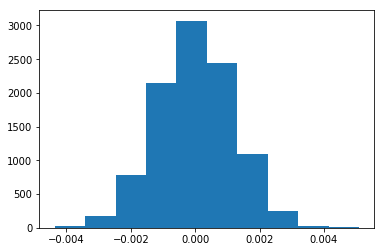

In [37]:
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

**Answer:**

+  94.49% of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**

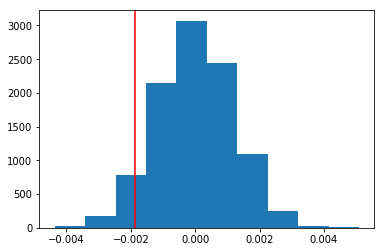

In [38]:
plt.hist(p_diffs)

plt.axvline(x = obs_diff, color = "red")

In [39]:
prop = np.count_nonzero(p_diffs - obs_diff > 0) / 10000

prop

0.9449

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer:**

+ We compute the proportion of the simulated differences between the proportion of the users converted using the old page and the proportion of the users converted using the old page. This proportion is the area under the curve to the right of the observed difference and it is the **p-value** in scientific studies.

+ This value means there is a 94.49% chance the convert proportion of the new page is greater than the convert proportion of the old page (the alternative hypothesis), given that the convertion proportion of the new page is less than or equal to the convertion proportion of the old page (the null hypothesis). This probability is much higher than 5% (our significant value); therefore, we fail to reject the null hypothesis. We can conclude that the new page does not make a difference in proportion of users converting.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [40]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"')['converted'].sum()
convert_new = df2.query('group == "treatment"')['converted'].sum()
n_old = df2.query('group == "control"').shape[0]
n_new = df2.query('group == "treatment"').shape[0]

In [41]:
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [42]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

In [43]:
from scipy.stats import norm

# The significance of our z-score? (http://knowledgetack.com/python/statsmodels/proportions_ztest/)
print(norm.cdf(z_score))

0.09494168724097551


In [44]:
# Critical value at 95% confidence (http://knowledgetack.com/python/statsmodels/proportions_ztest/)
print(norm.ppf(1-(0.05/2)))

1.959963984540054


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer:**
+ For our z_score, we will compare our z_score with the critical value at 95% confidence. Our z_score is -1.31, which is much smaller than the critical value at 1.96, we fail to reject the null hypothesis. 
+ For our p_value, we will compare it with the significance level alpha at 0.05. Since our p-value at 0.91 is much larger than the alpha level at 0.05, we fail to reject the null hypothesis.
+ Both the z-score and p-value agree with the findings in parts **j.** and **k.**. We **fail to reject** the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer:**

+ We will perform a logistic regression as in logistic regresion as our dependent variable is categorical.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [46]:
# Review the first few rows of our dataset
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [47]:
# Add an "intercept" column and an "ab_page" column

df2['intercept'] = 1

df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])

df2 = df2.drop('control', axis = 1)

In [48]:
# Double check to see if we have the desired dataframe
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [49]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [50]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 18 Jan 2019   Pseudo R-squ.:               8.077e-06
Time:                        08:36:32   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Answer:** 

(http://blog.minitab.com/blog/adventures-in-statistics-2/how-to-interpret-regression-analysis-results-p-values-and-coefficients)

+  The p-value associated with **ab_page** is 0.19. It is different from the value I found in **Part II** because these two p-values indicate two different approaches. 
    + The p-value in **Part II** is the probability of  observing the data more extreme in favor of the alternative hypothesis given that the null hypothesis is true. In this case, this probability is very high (>0.9) compared to our significance value at 0.05, therefore we fail to reject the null hypothsis. 
    + The p-value is the model output (**Part III**) tests the null hypothesis that the corresponding coefficient is equal to zero, which means no effect. A p-value lower than 0.05 means we can reject the null hypothesis and support the alternative, which means the corresponding predictor is a meaningful addition to the regression model. On the other hand, a p-value greater than 0.05 means we fail to reject the null hypothesis as the addition of the corresponding predictor is not meaningful to the model. In other words, changes in the corresponding predictor and changes in the response are not associated. In this case, the p-value for the coefficient corresponding to **ab_page** is 0.19, which is insignificant, suggesting that adding this predictor to our model is not meaningful. This agrees with our conclusion from **Part II.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer:**

+  In general, a more robust model involves more than one predictor as more often than not, more than one predictors are associated with the outcome. For example, for this particular problem, we can add the duration each user spends on the old page/ new page; we can hypothesize that the longer the duration, the more interest a user has and that will more than likely lead to a conversion. 

+  Even though adding more predictors can make our model more robust, we need to be careful and not overdo it. Adding too many factors can introduce multicollinearity and make our model unnecessarily more complex. A reasonable approach is brainstorming which factors will likely influence the outcome and adding one at a time and check our model performance after each addition. We need to also check for multicollinearity regularly.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [51]:
# Read in the 'countries' file and examine the first few rows
countries = pd.read_csv('countries.csv')

countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [52]:
# Review the first few rows in our dataframe "df2" before joining
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [53]:
# The two dataframes have the 'user_id' column in common. We will perform an inner join 
    # and examine the first few rows of our dataset

df_new = countries.set_index('user_id').join(df2.set_index('user_id'), how = 'inner')

df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [54]:
# Let's check to see how many unique values of countries there are
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [55]:
# Since there are three unique values for countries ('US', 'UK', and 'CA'), 
 # we will create three dummy variables and drop one. 

df_new[['US', 'UK', 'CA']] = pd.get_dummies(df_new['country'])

df_new = df_new.drop('US', axis = 1)

df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,CA
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


In [56]:
# Fit a logistic regression by creating an intercept column, instantiate the model, 
 # fit the model, and examine the results
    
df_new['intercept'] = 1

logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'UK','CA']])

results = logit_mod.fit()

results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 18 Jan 2019   Pseudo R-squ.:               1.521e-05
Time:                        09:02:00   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
CA             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

+  Since both p-values are not significant (0.074 and 0.129 are both greater than 0.05), it does not appear that country had an impact on conversion 

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [57]:
# Examine the first few rows of our dataframe one more time 
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,CA
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0


In [58]:
# Fit our logistic regression. This time we will include all three predictors: 'ab_page', 'UK', and 'CA'

logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'CA']])

results = logit_mod.fit()

results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 18 Jan 2019   Pseudo R-squ.:               2.323e-05
Time:                        09:03:18   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
CA             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

<a id='conclusions'></a>
## Conclusions

In this project, we perform an **A/B Testing** to test the effect of the new page: whether or not the proportion of users converted using the new page is greater than the proportion of users converted using the old page and if the difference is statistically significant. 

In order to do so, we utilize two approaches: bootstrapping and logistic regression. 

+  In bootstrapping approach, we simulate the proportion difference utilizing bootstrapping and compare that to the observed difference. We come to a conclusion that such a high p-value indicates we fail to reject the null hypothesis. The proportion of users converting using the new page is not greater than the proportion of users converting using the old page, statistically speaking. It's important to keep in mind that pratically speaking, it doesn't mean the proportion of users converting using the old page is always greater. It simply means the proportion difference is not statistically significant and also not practically significant to implement the new page. We can either cancel the project, implement a different new page, or depending on other factors, let the new page run for a little longer to see if there will be a change in the effect. 

+  In logistic regression approach, we fit a couple of models. All models have conversion rate (proportion) as our dependent variable. 
    + For the first model, we choose the control/treatment as our predictor and we come to the same conclusion as our bootstrapping approach. The addition of the control/treatment is not meaningful to our model, which means the change in conversion based on the new page is not associated with the change in the establishment of the treatment (implementing the new page).
    + We utilize a completely different variable for our second model: the country where each user is from. Similarly, the addition of this variable is not meaningful to our model.
    + For our third model, we utilize both the "country" variable and the "control/treatment" variable and this also does not bring any significant change in the result. The implementation of the new page does not bring a statistical and practical difference to the proportion of users converted. 
    
With the essentially same results from our two approaches for A/B Testing, we can conclude that we will either stick with the old page or let the new page run a little longer to see if there will be a different effect and perform the test again. Depending on the budget and time constraints, we can choose one approach wisely. 